In [ ]:
# !pip install --upgrade scikit-learn

### 1. Imports des modules

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from statistics import mean 

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


### 2. Lecture des données

In [2]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

### 3. Preparation des donnees Smartwatch

In [3]:
data = {}

data['heart_rate'] = [None] * len(smartwatch_df)
data['steps'] = [None] * len(smartwatch_df)
data['accelerometer'] = [None] * len(smartwatch_df)



for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]

    if row['source'] == 'step_detector':
        data['steps'][index] = values[0]
    
    if row['source'] == 'accelerometer':
        data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

smartwatch_df["heart_rate"] = data['heart_rate']
smartwatch_df["steps"] = data['steps']
smartwatch_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'heart_rate': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['heart_rate'].notnull() | 
                                smartwatch_df['steps'].notnull() |
                                smartwatch_df['accelerometer'].notnull()
    
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df[['heart_rate','steps', 'accelerometer']]
smartwatch_df = smartwatch_df.resample('min').agg(resampling_functions)
smartwatch_df['steps'].fillna(0.0, inplace=True)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

,heart_rate,steps,accelerometer
timestamp,,,
2017-06-29 07:46:00,129.568182,0.0,9.871610
2017-06-29 07:47:00,111.095238,2.0,9.870039
2017-06-29 07:48:00,75.076923,2.0,9.941302
2017-06-29 07:49:00,68.076923,2.0,9.873130
2017-06-29 07:50:00,64.666667,0.0,9.451193


In [ ]:
# smartwatch_df.loc[smartwatch_df['steps']<=3, 'steps'] = 0
# smartwatch_df.loc[smartwatch_df['steps']>3, 'steps'] = 1
# smartwatch_df.head()

### 3. Preparation des donnees Smartphone

In [4]:
data = {}

# data['activity'] = [None] * len(smartphone_df)

data['light'] = [None] * len(smartphone_df)
data['audio'] = [None] * len(smartphone_df)
data['steps'] = [None] * len(smartphone_df)
data['wifi'] = [None] * len(smartphone_df)
data['bluetooth'] = [None] * len(smartphone_df)
data['accelerometer'] = [None] * len(smartphone_df)


for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    
    if row['source'] != 'activity':
        values = [ float(x) for x in ast.literal_eval(row['values']) ]
#     else:
#         data['activity'][index] = values[0]
    
        if row['source'] == 'light':
            data['light'][index] = values[0]

        if row['source'] == 'audio':
            data['audio'][index] = mean(values)

        if row['source'] == 'step_detector':
            data['steps'][index] = values[0]

        if row['source'] == 'accelerometer':
            data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

        if row['source'] == 'wifi':
            data['wifi'][index] = len(values)

        if row['source'] == 'bluetooth':
            data['bluetooth'][index] = len(values)
        

# smartwatch_df["activity"] = data['activity']
smartphone_df["light"] = data['light']
smartphone_df["audio"] = data['audio']
smartphone_df["wifi"] = data['wifi']
smartphone_df["bluetooth"] = data['bluetooth']
smartphone_df["steps"] = data['steps']
smartphone_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'light': np.mean,
    'audio': np.mean,
    'wifi': np.mean,
    'bluetooth': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartphone_df = smartphone_df[ 
                    smartphone_df['light'].notnull() | 
                    smartphone_df['audio'].notnull() | 
                    smartphone_df['wifi'].notnull() | 
                    smartphone_df['bluetooth'].notnull() | 
                    smartphone_df['steps'].notnull() |
                    smartphone_df['accelerometer'].notnull()
                             ]

smartphone_df = smartphone_df.set_index('timestamp')
smartphone_df = smartphone_df[['light','audio','wifi','bluetooth', 'steps', 'accelerometer']]
smartphone_df = smartphone_df.resample('min').agg(resampling_functions)
smartphone_df['steps'].fillna(0.0, inplace=True)
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=1528218), HTML(value='')))

,light,audio,wifi,bluetooth,steps,accelerometer
timestamp,,,,,,
2017-06-29 09:14:00,2.406000,11514.733828,63.666667,3.000000,0.0,9.499753
2017-06-29 09:15:00,2.140667,12407.258311,63.833333,2.000000,21.0,10.430474
2017-06-29 09:24:00,2.406000,13915.343292,57.000000,2.500000,117.0,13.030613
2017-06-29 09:50:00,2.406000,12875.062890,72.000000,2.000000,82.0,10.196775
2017-06-29 09:51:00,0.680667,13491.104540,65.200000,2.333333,116.0,14.664845


### 3. Jointure des datasets

In [5]:
df = smartwatch_df.join(smartphone_df, lsuffix='_sw', rsuffix='_sp')
df.describe()

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp
count,3185.000000,3185.000000,3185.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,71.780527,4.605338,10.201539,19.646106,12448.451764,10.135116,1.634831,54.753623,10.776955
std,15.208808,15.734497,1.806241,130.583384,2221.661539,16.439799,0.700957,45.212549,1.921857
min,0.000000,0.000000,4.569840,0.067500,8798.278130,0.000000,1.000000,0.000000,8.670371
25%,62.625000,0.000000,9.729646,0.957750,10714.021272,3.333333,1.000000,14.000000,9.629167
50%,68.000000,0.000000,9.860604,2.406000,11811.312236,4.666667,1.500000,43.000000,10.011621
75%,76.000000,2.000000,10.034333,6.323000,13916.817237,7.700000,2.000000,106.000000,11.262799
max,166.800000,224.000000,41.990548,1991.272800,17952.417105,109.200000,5.000000,147.000000,23.478655


In [6]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [7]:
data = {}
data['activity_index'] = [None] * len(df)
data['activity_type'] = [None] * len(df)

i=0
for index, row in tqdm(df.iterrows(), total=len(df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_index'][i] = int(report_row['index'])
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

df["activity_index"] = data['activity_index']
df["activity_type"] = data['activity_type']
df = df.dropna()
df.head()

HBox(children=(IntProgress(value=0, max=3185), HTML(value='')))

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp,activity_index,activity_type
timestamp,,,,,,,,,,,
2017-06-29 09:57:00,76.083333,32.0,10.090378,0.534667,12883.949970,47.125000,2.5,91.0,12.654205,12.0,Eat
2017-06-29 09:58:00,83.500000,8.0,12.114484,2.406000,12258.789152,56.750000,2.0,53.0,10.117409,12.0,Eat
2017-06-29 10:01:00,58.784810,1.0,10.004682,1.282167,12155.157763,60.000000,2.5,50.0,9.982670,12.0,Eat
2017-06-29 10:02:00,71.727273,55.0,12.531055,2.406000,13177.428694,65.666667,3.0,107.0,10.720635,12.0,Eat
2017-06-29 10:03:00,91.750000,14.0,10.724664,2.406000,12905.517089,65.500000,3.5,91.0,10.717644,12.0,Eat


### 3. Exploration des donnees

In [8]:
df.describe()

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp,activity_index
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,73.643928,8.957831,10.280764,27.109586,12193.562050,10.458933,1.605823,50.807229,10.672710,6.849398
std,13.569299,18.729122,1.486605,186.528018,2239.919074,18.379476,0.722677,43.787769,1.759428,4.170048
min,52.583333,0.000000,6.277848,0.079167,8798.278130,0.000000,1.000000,0.000000,9.003681,0.000000
25%,63.071429,0.000000,9.648302,0.608812,10575.805295,3.308333,1.000000,13.000000,9.629570,4.000000
50%,71.527778,1.500000,9.846858,1.604000,11678.945149,4.500000,1.500000,38.500000,9.982518,7.000000
75%,83.408333,6.000000,10.517210,2.554275,13593.895204,6.541667,2.000000,97.000000,11.011844,10.000000
max,110.700000,117.000000,15.728876,1991.272800,17657.691431,109.200000,5.000000,147.000000,19.418213,18.000000


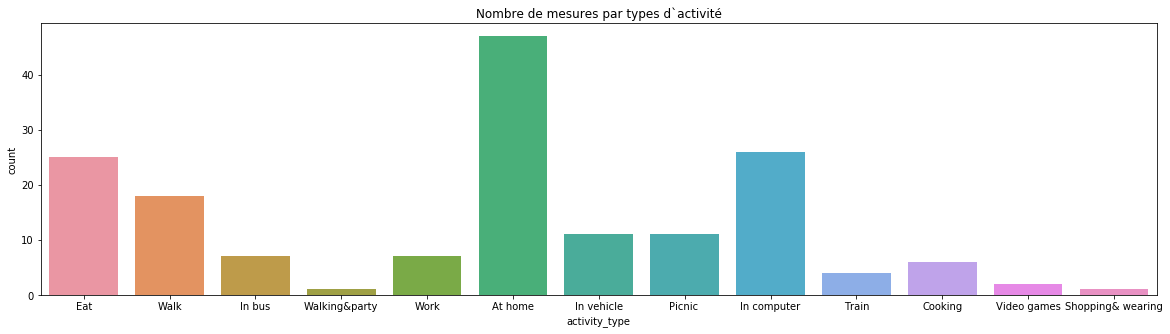

In [9]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

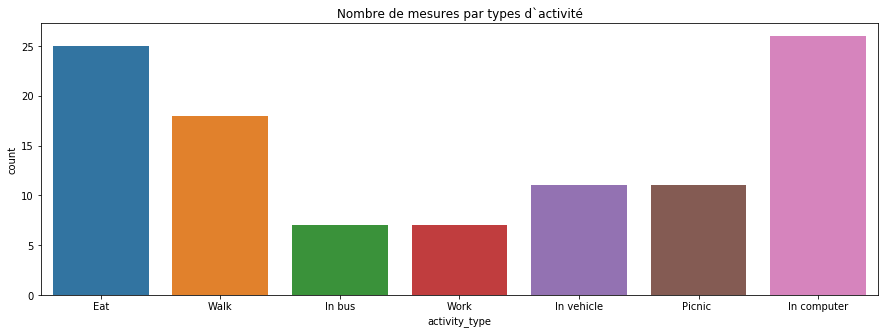

In [10]:
df = df.drop(df.index[df['activity_type'] == 'At home'], axis = 0)
df = df.drop(df.index[df['activity_type'] == 'Walking&party'], axis = 0)
for activity_type in df['activity_type'].unique():
    if len(df[df['activity_type'] == activity_type])<7:
        df = df.drop(df.index[df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

In [11]:
list(df.columns)

['heart_rate',
 'steps_sw',
 'accelerometer_sw',
 'light',
 'audio',
 'wifi',
 'bluetooth',
 'steps_sp',
 'accelerometer_sp',
 'activity_index',
 'activity_type']

In [14]:
variables = [
    'heart_rate',
    'steps_sw',
    'accelerometer_sw',
    'light',
    'audio',
    'wifi',
    'bluetooth',
    'steps_sp',
    'accelerometer_sp',
]

# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(df[variables])
normal = normal_scaler_fit.transform(df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(normal, columns=variables)

y = df['activity_type']

df_normal = pd.DataFrame(normal, columns=variables)
df_normal['activity_type'] = df['activity_type'].tolist()

In [16]:
df_normal.head()

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp,activity_type
0,0.151461,1.110442,-0.010443,-0.329739,0.075462,1.529298,1.203304,0.860749,1.425314,Eat
1,0.693792,-0.076793,1.432409,-0.263746,-0.217961,1.966244,0.548204,0.001507,-0.271439,Eat
2,-1.113463,-0.423071,-0.071530,-0.303379,-0.266601,2.113784,1.203304,-0.066327,-0.361560,Eat
3,-0.167068,2.248210,1.729356,-0.263746,0.213208,2.371034,1.858403,1.222536,0.132032,Eat
4,1.297059,0.220016,0.441698,-0.263746,0.085585,2.363468,2.513503,0.860749,0.130032,Eat


In [17]:
df[variables].describe()

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,74.012017,9.552381,10.105028,9.884913,12723.172058,13.437823,1.581587,52.933333,10.523235
std,13.741127,20.311981,1.409579,28.492468,2140.798342,22.133526,0.766903,44.437135,1.502259
min,52.928571,0.000000,6.277848,0.079167,8851.812762,0.000000,1.000000,0.000000,9.003681
25%,63.000000,0.000000,9.646473,0.630750,11005.969828,3.333333,1.000000,15.000000,9.530863
50%,72.333333,1.000000,9.810129,1.923250,12803.738856,4.666667,1.500000,43.000000,9.921801
75%,83.500000,6.000000,10.255575,4.966000,14095.825859,8.833333,2.000000,98.000000,11.011146
max,110.700000,117.000000,15.505229,218.244652,17657.691431,109.200000,5.000000,147.000000,17.182533


In [18]:
df_normal.describe()

,heart_rate,steps_sw,accelerometer_sw,light,audio,wifi,bluetooth,steps_sp,accelerometer_sp
count,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02
mean,1.199041e-15,-6.026925e-17,1.053126e-15,-1.163091e-17,1.054844e-15,-1.586033e-16,-5.286776e-17,4.863834e-17,-1.031979e-15
std,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00
min,-1.541691e+00,-4.725387e-01,-2.728146e+00,-3.458028e-01,-1.817045e+00,-6.100372e-01,-7.619953e-01,-1.196909e+00,-1.016364e+00
25%,-8.052347e-01,-4.725387e-01,-3.268736e-01,-3.263511e-01,-8.059789e-01,-4.587138e-01,-7.619953e-01,-8.577346e-01,-6.637543e-01
50%,-1.227508e-01,-4.230705e-01,-2.102145e-01,-2.807706e-01,3.781450e-02,-3.981844e-01,-1.068956e-01,-2.246089e-01,-4.022733e-01
75%,6.937924e-01,-1.757297e-01,1.073151e-01,-1.734671e-01,6.442631e-01,-2.090301e-01,5.482041e-01,1.019031e+00,3.263426e-01
max,2.682745e+00,5.315235e+00,3.849449e+00,7.347874e+00,2.316045e+00,4.347318e+00,4.478802e+00,2.127001e+00,4.454117e+00


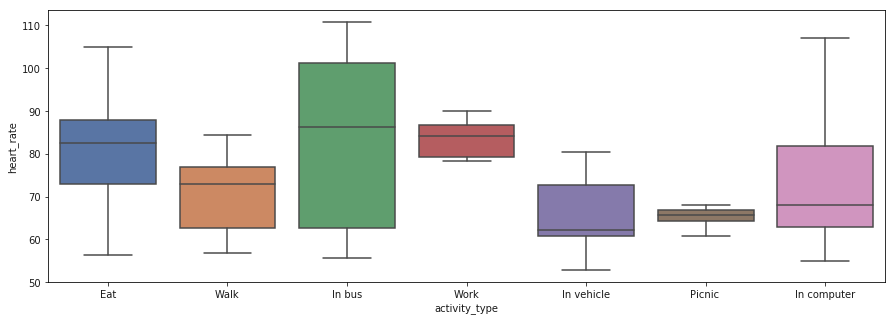

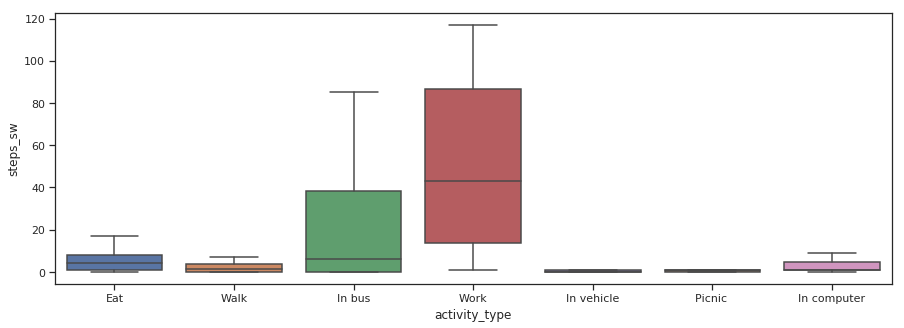

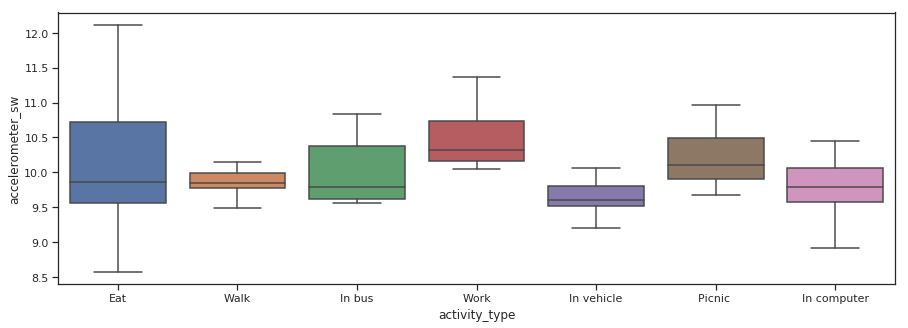

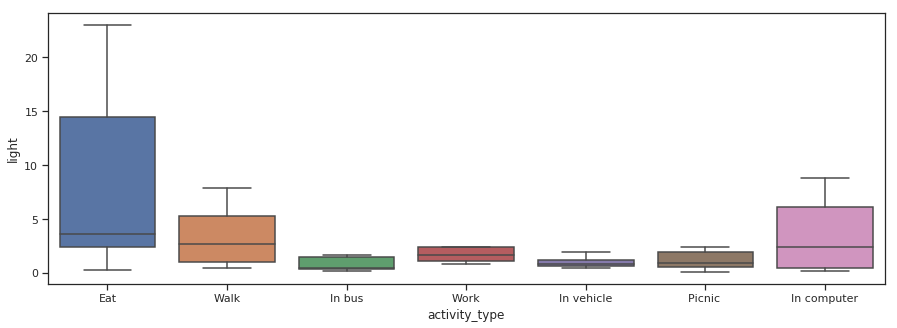

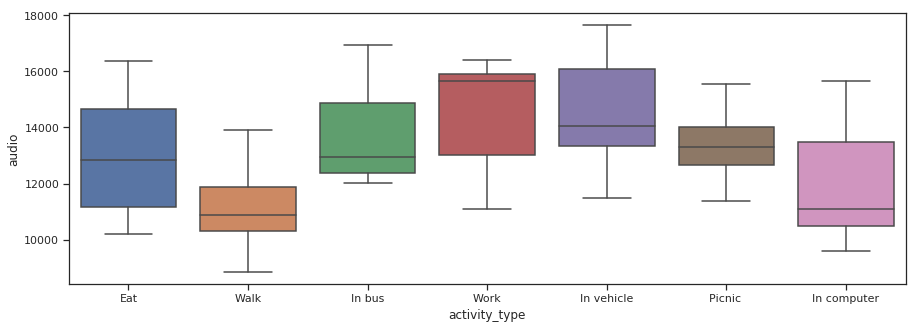

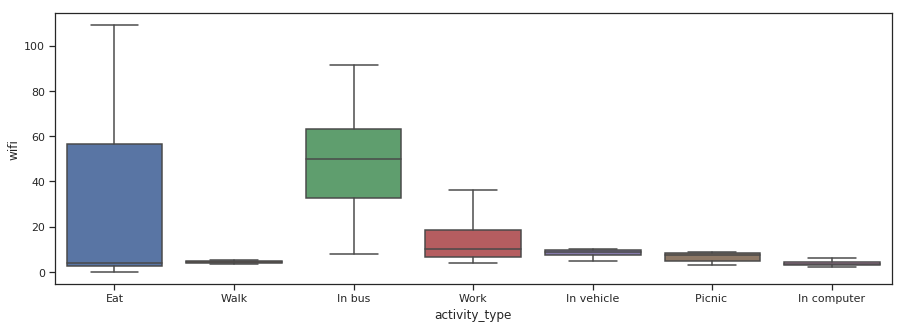

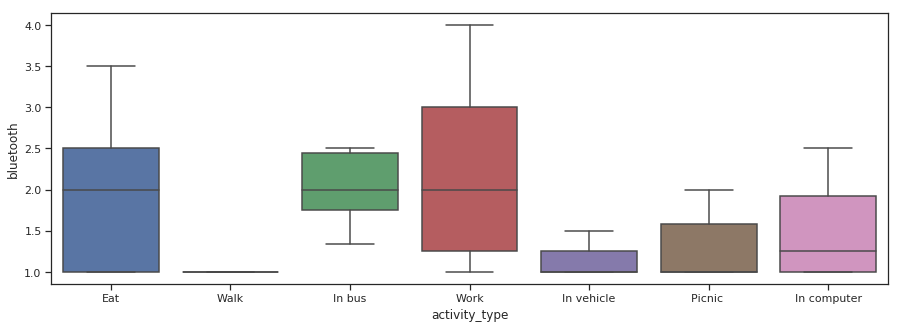

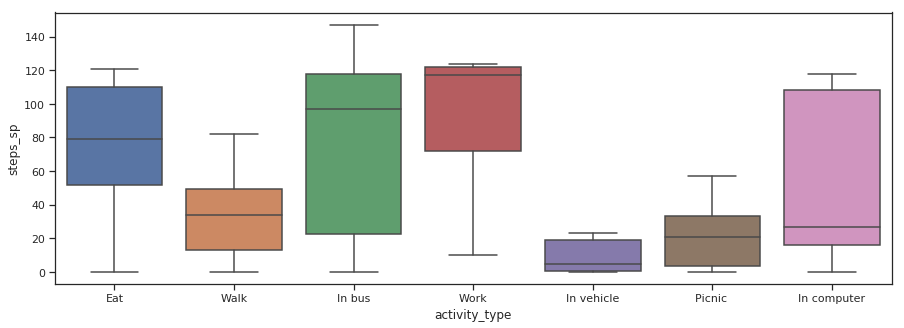

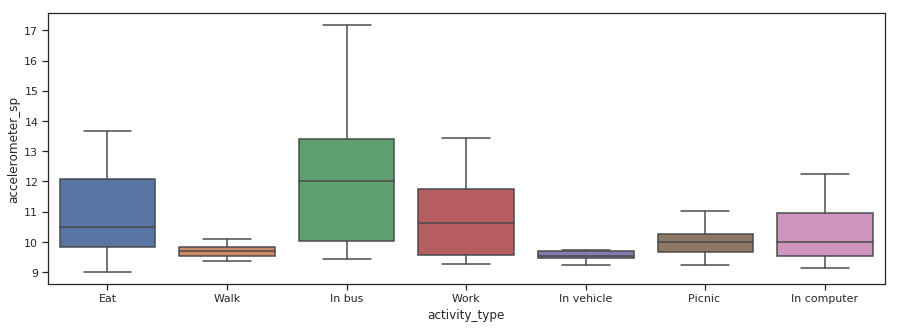

In [19]:
for variable in variables:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(style="ticks", color_codes=True)
    sns.boxplot(x="activity_type", y=variable, data=df, showfliers=False)

### 4.  Corrélations

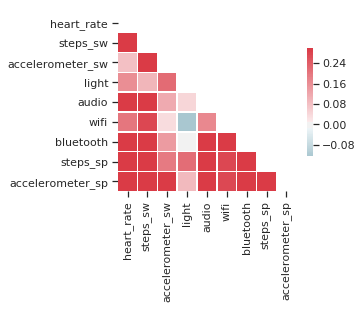

In [20]:
# Matrice de correlation
corr = X.corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

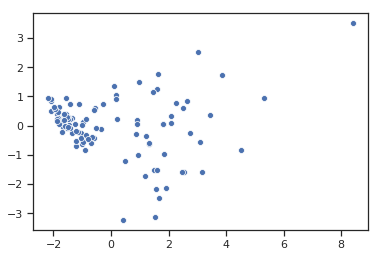

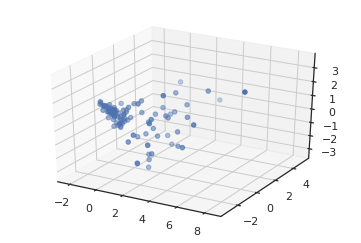

 
Explained variances:
[0.4203552835756376, 0.14659734886494052, 0.11141384839257251]
 
Sum of explained variances: 0.6783664808331507
 


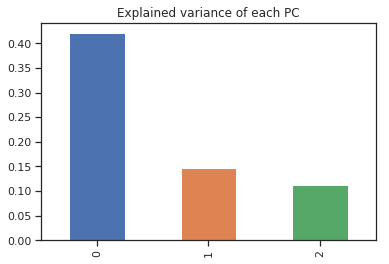

In [21]:
n_components = 3
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

## 5. Classification non-supervisée

### 5.1. CAH

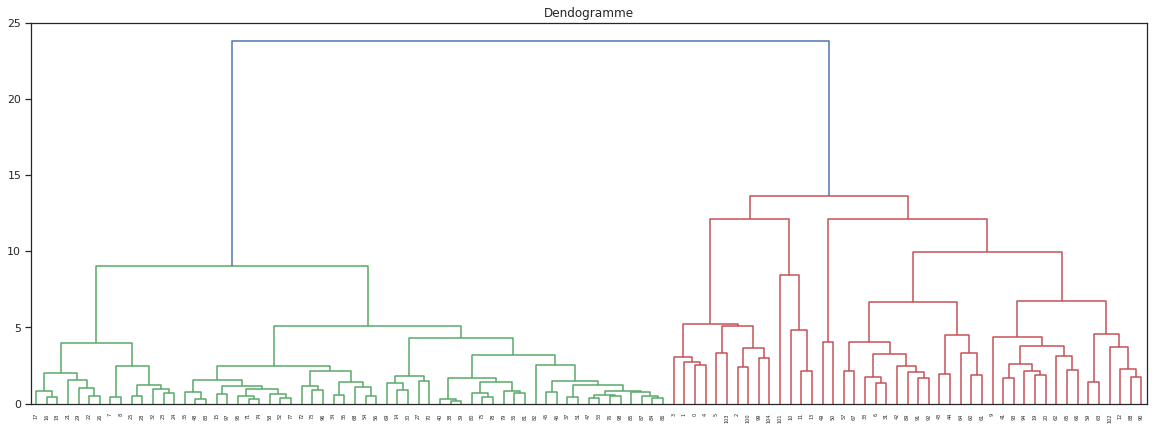

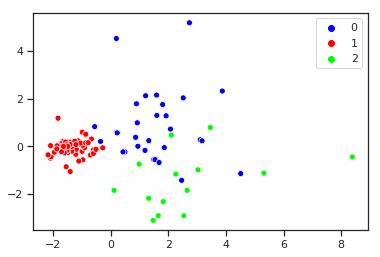

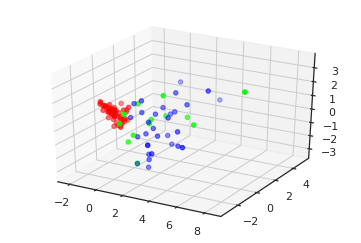

In [22]:
plt.figure(figsize=(20, 7))  
plt.title("Dendogramme")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))    

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X) 

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=cluster.labels_, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=cluster.labels_, cmap = 'brg') 

### 5.2. K-Means

#### 5.2.1. Sans PCA

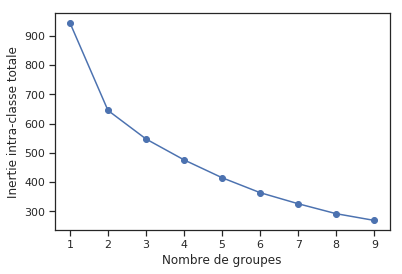

Centres des classes:
   heart_rate  steps_sw  accelerometer_sw     light     audio      wifi  \
0   -0.578968 -0.375101         -0.105018 -0.143074 -0.425451 -0.316190   
1    0.979792  0.634787          0.177723  0.242125  0.719995  0.535092   

   bluetooth  steps_sp  accelerometer_sp  
0  -0.464223 -0.672045         -0.482605  
1   0.785608  1.137307          0.816716  


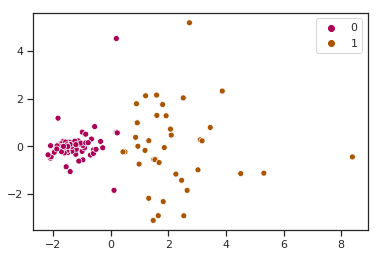

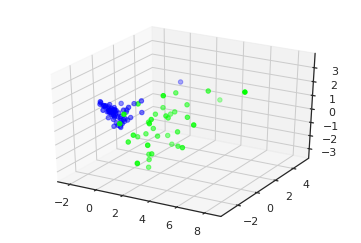

In [25]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 2
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

print('Centres des classes:')
print(centers_km)

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg') 

#### 5.2.2. Avec PCA

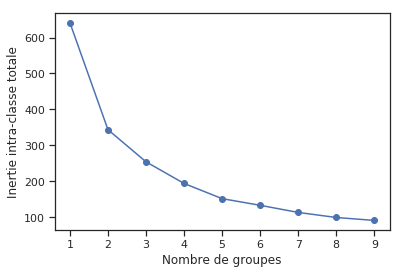

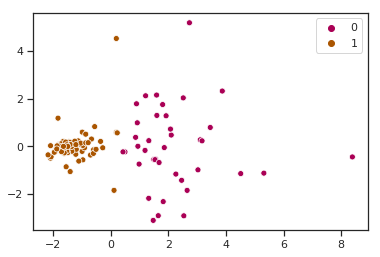

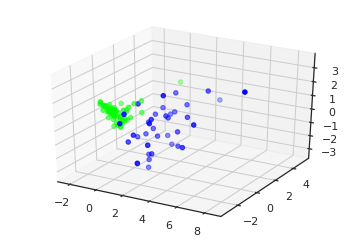

In [29]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X_pca)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 2
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X_pca)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
# centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

# print('Centres des classes:')
# print(centers_km)

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg') 

In [ ]:
y = pd.DataFrame(y)
y['km_prediction']=km_labels
for activity_type in y['activity_type'].unique():
    data = y[y['activity_type'] == activity_type]
    plt.show()
    sns.countplot(x="km_prediction", data=data).set_title(activity_type)

### 5. Classification

#### Sans l'ACP:

In [ ]:
# activites_mobiles = ['Walk','Cooking', 'Football']
# labels = []
# for activity_type in list(y['activity_type']):
#     if activity_type in activites_mobiles:
#         labels.append(1)
#     else:
#         labels.append(0)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, list(y), test_size=0.3, random_state=101)

In [34]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, list(y), cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.44
Nearest Neighbors cross-validated scores: 
[0.39473684 0.37142857 0.3125    ]




Decision Tree score: 0.41
Decision Tree cross-validated scores: 
[0.31578947 0.4        0.1875    ]




#### Avec l'ACP:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=101)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.31
Nearest Neighbors cross-validated scores: 
[0.39473684 0.37142857 0.3125    ]




Decision Tree score: 0.34
Decision Tree cross-validated scores: 
[0.31578947 0.34285714 0.125     ]


